# Indeed Machine Learning Hackathon

In [1]:
import preprocessing as pp
import re
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pp.JobDescriptionDataset("./data/train.tsv")

In [3]:
dt_matrix = train.getDTMatrix()
corr_matrix = train.getCorrelationMatrix()

In [4]:
corr_matrix_sort = (-corr_matrix).argsort()
term_names = train.getTermNames()

### Descriptive Analysis

There are several training samples that are missing tags. In several cases, it seems like this is in error. For example, several contain the string 'full time' but aren't tagged with 'full-time-job'.

In [5]:
print "Number of training samples without tags:", np.sum(np.array(train.getRawY()) == '')

Number of training samples without tags: 871


In [6]:
descriptions_missing_tags = np.array(train.getRawX())[np.array(train.getRawY()) == '']
contain_full_time = [re.search(".*full time.*", d) is not None for d in descriptions_missing_tags]
print "Training samples without tags that contain 'full time':", sum(contain_full_time)

Training samples without tags that contain 'full time': 33


As mentioned in the problem description, there are several tags that are mutually exclusive. The table below shows the cooccurrence of various tags in the training set. The (i,j) element of this matrix indicates the proportion of samples in which the i'th tag was assigned given that the j'th tag was assigned.

We see that the following tuples are mutually exclusive:
* '1-year-experience-needed', '2-4-years-experience-neeed', '5-plus-years-experience-needed'
* 'bs-degree-needed', 'associate-needed', 'ms-or-pd-needed', 'license-needed'
* 'salary', 'hourly-wage'
* 'full-time-job', 'part-time-job'

In [7]:
label_cooccurrence = train.getLabelCooccurrence()
label_cooccurrence_pretty = pd.DataFrame(label_cooccurrence)
label_cooccurrence_pretty.columns = pp.LABEL_LIST
label_cooccurrence_pretty.index = pp.LABEL_LIST
display(label_cooccurrence_pretty)

,1-year-experience-needed,2-4-years-experience-needed,5-plus-years-experience-needed,associate-needed,bs-degree-needed,full-time-job,hourly-wage,licence-needed,ms-or-phd-needed,part-time-job,salary,supervising-job
1-year-experience-needed,1.000000,0.000000,0.000000,0.095694,0.067010,0.094915,0.079823,0.129771,0.060241,0.088415,0.074738,0.037284
2-4-years-experience-needed,0.000000,1.000000,0.000000,0.416268,0.358763,0.263277,0.146341,0.202290,0.253012,0.121951,0.272048,0.335553
5-plus-years-experience-needed,0.000000,0.000000,1.000000,0.119617,0.329897,0.149153,0.053215,0.080153,0.253012,0.018293,0.164425,0.304927
associate-needed,0.060423,0.083413,0.039308,1.000000,0.000000,0.055367,0.044346,0.000000,0.000000,0.045732,0.047833,0.046605
bs-degree-needed,0.196375,0.333653,0.503145,0.000000,1.000000,0.231638,0.082040,0.000000,0.000000,0.060976,0.267564,0.368842
full-time-job,0.253776,0.223394,0.207547,0.234450,0.211340,1.000000,0.303769,0.204198,0.277108,0.000000,0.388640,0.223702
hourly-wage,0.108761,0.063279,0.037736,0.095694,0.038144,0.154802,1.000000,0.068702,0.000000,0.347561,0.000000,0.039947
licence-needed,0.205438,0.101630,0.066038,0.000000,0.000000,0.120904,0.079823,1.000000,0.000000,0.125000,0.131540,0.083888
ms-or-phd-needed,0.015106,0.020134,0.033019,0.000000,0.000000,0.025989,0.000000,0.000000,1.000000,0.006098,0.029895,0.035952
part-time-job,0.087613,0.038351,0.009434,0.071770,0.020619,0.000000,0.252772,0.078244,0.024096,1.000000,0.025411,0.015979


### Baseline Scoring

In [8]:
def baselineScore(tag, trueY):
    return pp.score([tag]*len(trueY), trueY)

In [9]:
trueY = train.getRawY()
tag_predictions = ['2-4-years-experience-needed', '2-4-years-experience-needed bs-degree-needed', 
                   '2-4-years-experience-needed bs-degree-needed full-time-job', 
                   '2-4-years-experience-needed bs-degree-needed full-time-job supervising-job']
for i, t in enumerate(tag_predictions):
    print "PopularTag%s:" % str(i + 1), baselineScore(t, trueY)

PopularTag1: (0.2384, 0.1515988372093023, 0.18533984895601954)
PopularTag2: (0.23005714285714285, 0.29258720930232557, 0.25758157389635317)
PopularTag3: (0.2208, 0.42122093023255813, 0.289727568107973)
PopularTag4: (0.2085142857142857, 0.5303779069767441, 0.2993437243642329)


### Keyword Model

First, I'll look at the terms (unigrams/bigrams) most highly correlated with each label.

In [10]:
top_terms = list()
for i, t in enumerate(corr_matrix_sort[:, :5].tolist()):
    top_terms.append([pp.LABEL_LIST[i]] + [term_names[j] for j in t])

In [11]:
top_terms_table = pd.DataFrame(top_terms)
top_terms_table.columns = ["Tag"] + ["Term %s" % str(i) for i in range(1, 6)]
display(top_terms_table)

,Tag,Term 1,Term 2,Term 3,Term 4,Term 5
0,1-year-experience-needed,1 year,year,1,year of,1 year of
1,2-4-years-experience-needed,years,2 years,3 years,years of,2
2,5-plus-years-experience-needed,5 years,5,years,5 years of,5 years experience
3,associate-needed,associates degree,associates,associates degree or,degree,associates degree in
4,bs-degree-needed,degree,bachelors,bachelors degree,degree in,bachelor
5,full-time-job,full-time,full time,a full-time,full,a full time
6,hourly-wage,hour,per hour,hourly,00,00 per hour
7,licence-needed,nurse,rn,licensed,care,nursing
8,ms-or-phd-needed,masters,masters degree,masters degree in,clinical,of clinical
9,part-time-job,part time,part-time,a part time,a part-time,week


Next, I'll build a model that predicts based off of the presence of correlated terms. More specifically, if a sample contains the top two terms for a given tag, then that sample is assigned that tag.

In [12]:
def topKeywordModel(dt_matrix, corr_matrix):
    train_preds = list()
    corr_matrix_sort = (-corr_matrix).argsort()
    for i in range(dt_matrix.shape[0]):
        pred = list()
        for j in range(len(pp.LABEL_LIST)):
            top_terms = corr_matrix_sort[j, :2].tolist()[0]
            if dt_matrix[i, top_terms[0]] == 1 and dt_matrix[i, top_terms[1]] == 1:
                pred.append(pp.LABEL_LIST[j])
        train_preds.append(" ".join(pred))
    return train_preds

In [13]:
train_preds = topKeywordModel(dt_matrix, corr_matrix)
print "Top Correlated Keyword:", pp.score(train_preds, train.getRawY())

Top Correlated Keyword: (0.755586592178771, 0.23590116279069767, 0.35954807266282673)


### Build Validation and Test Set

In [14]:
top_terms = np.array(list(set(corr_matrix_sort[:, :15].flatten().tolist()[0])))

In [15]:
X = train.getDTMatrix()
X = X[:, top_terms]
print X.shape

(4375, 171)


In [16]:
y = train.getBinarizedLabels()

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=24)

In [18]:
y_train_str = pp.labelMatrixToString(y_train.todense().tolist())
y_val_str = pp.labelMatrixToString(y_val.todense().tolist())

In [19]:
non_empty_samples = np.array(y_train_str) != ''
X_train_drop_neg = X_train[non_empty_samples]
y_train_drop_neg = y_train[non_empty_samples]

In [20]:
test = pp.JobDescriptionDataset("./data/test.tsv")

In [21]:
test.setDTMatrix(vocab = np.array(train.getTermNames())[top_terms])
X_test = test.getDTMatrix()

### OneVsRest SVM

In [22]:
ovr_svm = OneVsRestClassifier(SVC(kernel = 'linear', probability = True, random_state = 20))

In [23]:
ovr_svm.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=20, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1)

In [24]:
pred_matrix = ovr_svm.predict(X_val)

In [25]:
pred_str = pp.labelMatrixToString(pred_matrix.todense().tolist())

In [26]:
print "Validation Score:", pp.score(pred_str, y_val_str)
print "Training Score:", pp.score(pp.labelMatrixToString(ovr_svm.predict(X_train).todense().tolist()), y_train_str)

Validation Score: (0.7626582278481012, 0.589242053789731, 0.6648275862068965)
Training Score: (0.8188079470198676, 0.6392967942088935, 0.7180023228803716)


The precision is higher than the recall for this model which shows that it fails to predict many tags but does relatively well when it does predict a tag. This means that the model could likely benefit from predicting more tags to boost the true positive rate at the expense of increasing the false positive rate.

In addition, the average number of tags predicted per sample in the validation set is significantly lower than the average number of tags per sample in the training set. This is another indication that the model could benefit from predicting more tags.

In [27]:
print "Average Tags Per Validation Prediction:", 1.*pred_matrix.sum()/pred_matrix.shape[0]
print "Average Tags Per Training Sample:", 1.*y_train.sum()/y_train.shape[0]

Average Tags Per Validation Prediction: 1.20335110434
Average Tags Per Training Sample: 1.57903331156


We can do this by using SVM's probability estimates and lowering the threshold at which a sample is predicted to have a certain tag. We can choose this threshold by looking at performance results on the validation set using various threshold values.

In [28]:
pred_matrix_prob = ovr_svm.predict_proba(X_val)
pred_matrix_prob = pp.prunedProbMatrix(pred_matrix_prob)

In [29]:
grid_result = list()
for i in [.17 + incr for incr in np.divide(range(25), 100.)]:
    row = [i, 1.*(pred_matrix_prob > i).sum()/pred_matrix_prob.shape[0]]
    pred_matrix = pred_matrix_prob > i
    row += list(pp.score(pp.labelMatrixToString(pred_matrix), y_val_str))
    grid_result.append(row)
grid_result = np.array(grid_result)

In [30]:
grid_result_pretty = pd.DataFrame(grid_result)
grid_result_pretty.columns = ["Threshold", "Avg. Tags Per Prediction", "Val. Precision", "Val. Recall", "Val. F1"]
display(grid_result_pretty)

,Threshold,Avg. Tags Per Prediction,Val. Precision,Val. Recall,Val. F1
0,0.17,1.779893,0.629867,0.719804,0.671839
1,0.18,1.722772,0.645004,0.713447,0.677502
2,0.19,1.678599,0.656987,0.708068,0.681572
3,0.20,1.636710,0.666822,0.700733,0.683357
4,0.21,1.598629,0.676036,0.693888,0.684846
5,0.22,1.567403,0.682702,0.687042,0.684865
6,0.23,1.534653,0.689826,0.679707,0.684729
7,0.24,1.501904,0.698783,0.673839,0.686084
8,0.25,1.470678,0.705334,0.666015,0.685111
9,0.26,1.444021,0.710443,0.658680,0.683583


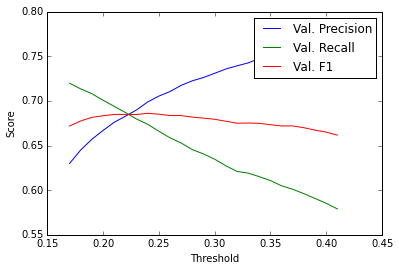

In [31]:
plt.plot(grid_result[:,0], grid_result[:,2:5])
plt.legend(["Val. Precision", "Val. Recall", "Val. F1"])
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.show()

In [32]:
print "Training Score:", pp.score(pp.labelMatrixToString(ovr_svm.predict_proba(X_train) > .235), y_train_str)

Training Score: (0.7496812579685508, 0.7296794208893485, 0.739545121056493)


I'll fit this model on all the data to make test predictions.

In [33]:
ovr_svm.fit(X, y)

OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=20, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1)

In [34]:
pred_matrix = ovr_svm.predict_proba(X_test) > .235
pred_str = pp.labelMatrixToString(pred_matrix.astype(int))
# pp.predStringToFile(pred_str, "./data/tags.tsv")

### OneVsRest Logistic Regression

In [35]:
ovr_lr = OneVsRestClassifier(LogisticRegression(random_state = 10))

In [36]:
ovr_lr.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=10, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [37]:
pred_matrix_prob = ovr_lr.predict_proba(X_val)
# pred_matrix_prob = pp.prunedProbMatrix(pred_matrix_prob)

In [38]:
grid_result = list()
for i in [.21 + incr for incr in np.divide(range(25), 100.)]:
    row = [i, 1.*(pred_matrix_prob > i).sum()/pred_matrix_prob.shape[0]]
    pred_matrix = pred_matrix_prob > i
    row += list(pp.score(pp.labelMatrixToString(pred_matrix), y_val_str))
    grid_result.append(row)
grid_result = np.array(grid_result)

In [39]:
grid_result_pretty = pd.DataFrame(grid_result)
grid_result_pretty.columns = ["Threshold", "Avg. Tags Per Prediction", "Val. Precision", "Val. Recall", "Val. F1"]
display(grid_result_pretty)

,Threshold,Avg. Tags Per Prediction,Val. Precision,Val. Recall,Val. F1
0,0.21,1.976390,0.603854,0.766259,0.675431
1,0.22,1.941356,0.610435,0.760880,0.677405
2,0.23,1.900990,0.618590,0.755012,0.680026
3,0.24,1.865956,0.625714,0.749633,0.682091
4,0.25,1.830922,0.632696,0.743765,0.683749
5,0.26,1.792079,0.641734,0.738386,0.686676
6,0.27,1.759330,0.649351,0.733496,0.688863
7,0.28,1.720487,0.656485,0.725183,0.689126
8,0.29,1.686215,0.663957,0.718826,0.690303
9,0.30,1.651181,0.672970,0.713447,0.692618


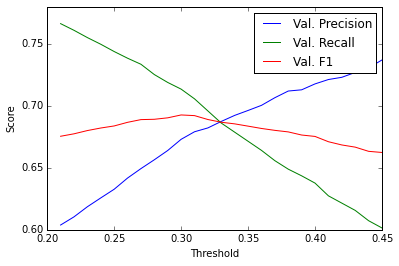

In [40]:
plt.plot(grid_result[:,0], grid_result[:,2:5])
plt.legend(["Val. Precision", "Val. Recall", "Val. F1"])
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.show()

In [41]:
print "Training Score:", pp.score(pp.labelMatrixToString(ovr_lr.predict_proba(X_train) > .3), y_train_str)

Training Score: (0.7089967389219259, 0.7644260599793175, 0.7356687898089171)


In [42]:
ovr_lr.fit(X, y)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=10, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [43]:
pred_matrix = ovr_lr.predict_proba(X_test) > .3
pred_str = pp.labelMatrixToString(pred_matrix.astype(int))
# pp.predStringToFile(pred_str, "./data/tags.tsv")